## *SMS-Spam-Classification Program*

## *1 . Import Libraries*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,f1_score
from sklearn.metrics import RocCurveDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import warnings
warnings.filterwarnings('ignore')


#### *Load the Dataset*

In [3]:
df=pd.read_csv("D:/sms_spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# basic info of dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## *2. Data Cleaning*

In [5]:
# Drop unnecessary columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [6]:
#Check the null values
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [7]:
# Rename of columns
df.rename(columns={'v1':'target','v2':'sms_text'},inplace=True)

In [8]:
# check the duplicate values
df.duplicated().sum()

np.int64(403)

In [9]:
# Drop the duplicated values
df.drop_duplicates(keep='first',inplace=True)

## 3. *Exploratery Data Analysis(EDA)*

In [10]:
df.target.value_counts()

target
ham     4516
spam     653
Name: count, dtype: int64

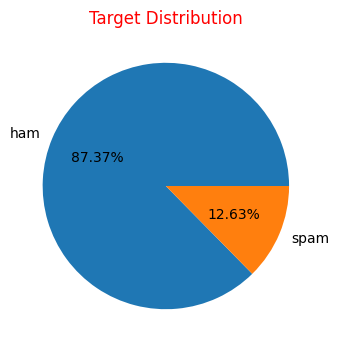

In [11]:
# Plot the target distribution
values=df['target'].value_counts().values
plt.figure(figsize=(6,4))
plt.pie(values,autopct='%.2f%%',labels=['ham','spam'])
plt.title('Target Distribution',c='r')
plt.show()

In [12]:
# Text length analysis
df['num_chars']=df['sms_text'].apply(len)
df['num_word']=df['sms_text'].apply(word_tokenize)
df['num_word']=df['num_word'].apply(len)
df['num_sent']=df['sms_text'].apply(sent_tokenize)
df['num_sent']=df['num_sent'].apply(len)

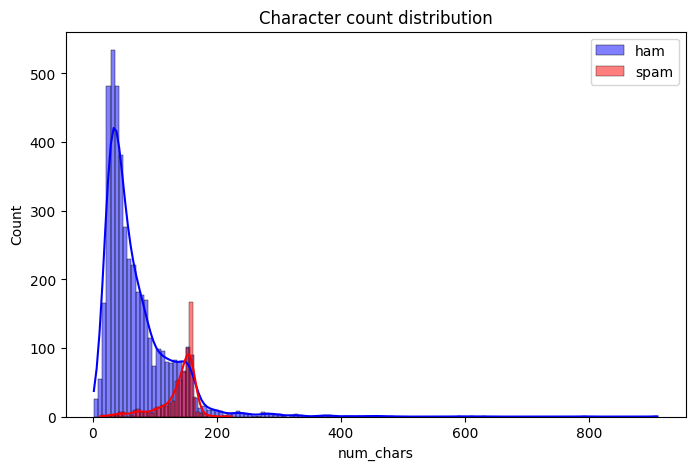

In [13]:
# Plot distribution of text length
plt.figure(figsize=(8,5))
sns.histplot(df[df['target']=='ham']['num_chars'],color='blue',label='ham',kde=True)
sns.histplot(df[df['target']=='spam']['num_chars'],color='red',label='spam',kde=True)
plt.legend()
plt.title('Character count distribution')
plt.show()

*Conclusion: We observe that ham messages are mostly short(0-100) characters,whereas spam messages tend to be longer and more verbose.*

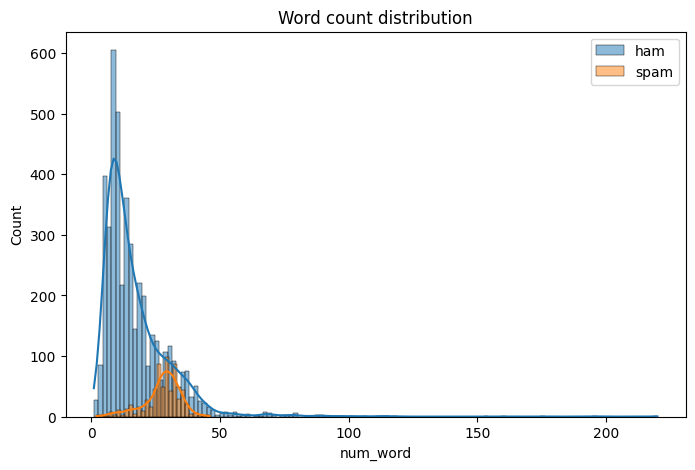

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['target']=='ham']['num_word'],label='ham',kde=True)
sns.histplot(df[df['target']=='spam']['num_word'],label='spam',kde=True)
plt.title('Word count distribution')
plt.legend()
plt.show()

*conclusion: From word count distribution clearly shows that ham messages usually contain fewer words (mostly 0-20),whereas spam messages tend to be longer,spreading.*

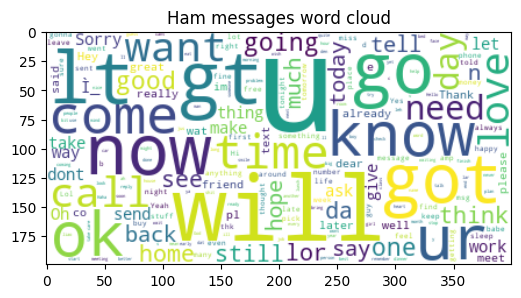

In [15]:
# Gnerate word cloud for ham messages
ham_words=''.join(word for word in df[df['target']=='ham']['sms_text'])
plt.figure(figsize=(6,5))
ham_wc=WordCloud(background_color='white')
ham_wc.generate(ham_words)
plt.imshow(ham_wc,interpolation='bilinear')
plt.title('Ham messages word cloud')
plt.show()

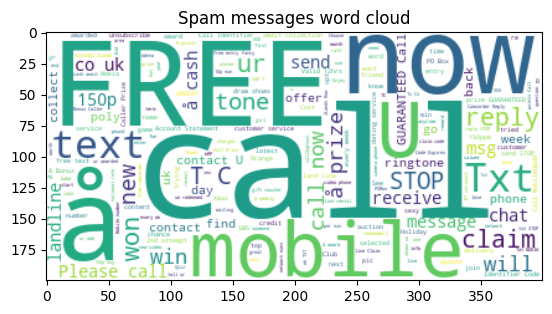

In [16]:
spam_words=''.join(word for word in df[df['target']=='spam']['sms_text'])
spam_wc=WordCloud(background_color='white')
spam_wc.generate(spam_words)
plt.imshow(spam_wc,interpolation='bilinear')
plt.title('Spam messages word cloud')
plt.show()

## *4. Data Preprocessing*

In [ ]:
# text lowercasing and removing punctuation,urls, numbers
punc=string.punctuation
def preprocess_text(text):
    text=text.lower()                                #text lowercasing
    text=re.sub(r'https?://\s+|www\.\s+','',text)    #remove url
    text=re.sub(r'\d+','',text)                      #remove numbers
    text=''.join([chr for chr in text if chr not in punc])  #remove punctuation
    return text

df['sms_text']=df['sms_text'].apply(lambda x:preprocess_text(x))

In [18]:
# tokenization,removing stopwords and lemmatize word
sw=stopwords.words('english')
lemmatizer=WordNetLemmatizer()
def tokenization(text):
    tokens=word_tokenize(text)                               #tokenize word
    tokens=[token for token in tokens if token not in sw]    #stopword removel
    tokens=[lemmatizer.lemmatize(token) for token in tokens] #lemmatize word
    return tokens

df['sms_text']=df.sms_text.apply(lambda x:tokenization(x))


In [19]:
 #Label encoding of target variables
le=LabelEncoder()
df['target']=le.fit_transform(df.target) # 0=ham,1=spam

#### *Tf-idf vectorization* 

In [20]:
# words to vectors convert using Tfidf-vectorizer
corpus=[' '.join(word) for word in df.sms_text]
tfidf_vectorizer=TfidfVectorizer(max_features=3000)
vectors=tfidf_vectorizer.fit_transform(corpus).toarray()

In [21]:
# shape of feature vectors
vectors.shape

(5169, 3000)

#### *Train-test-split data*

In [22]:
x=vectors
y=df.target

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)


In [24]:
#shape of train and test data
print(x_train.shape)
print(x_test.shape)

(4135, 3000)
(1034, 3000)


## 5. *Model build & Train*

In [25]:
model_mnb=MultinomialNB(alpha=0.2)
model_mnb.fit(x_train,y_train)
y_predict=model_mnb.predict(x_test)

## 6. *Model Evaluation*

In [26]:
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy score = ',accuracy)
prec=precision_score(y_test,y_predict)
print('Precision score = ',prec)
f1=f1_score(y_test,y_predict)
print("F1 score =",f1)

Accuracy score =  0.9777562862669246
Precision score =  0.9603174603174603
F1 score = 0.9132075471698113


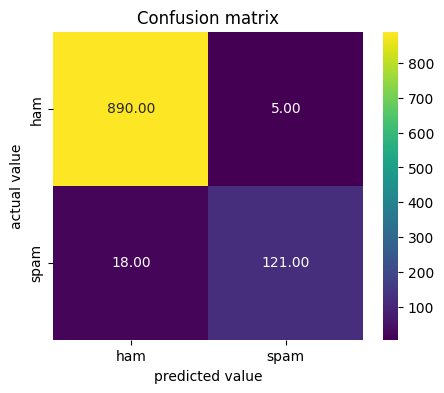

In [27]:
# plot confusion matrix
plt.figure(figsize=(5,4))
conf=confusion_matrix(y_test,y_predict)
sns.heatmap(conf,annot=True,fmt='.2f',cmap='viridis',xticklabels=['ham','spam'],yticklabels=['ham','spam'])
plt.title('Confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('actual value')
plt.show()

<Figure size 400x500 with 0 Axes>

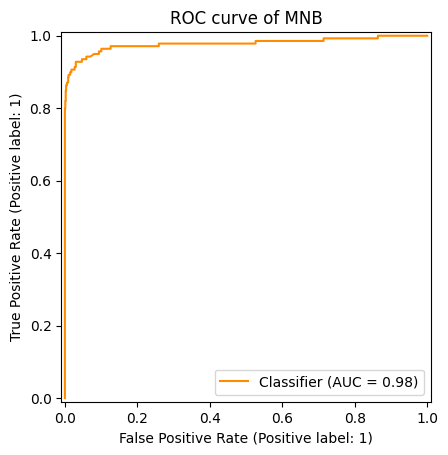

In [28]:
# Plot ROC_AUC curve
y_proba=model_mnb.predict_proba(x_test)[:,1]
plt.figure(figsize=(4,5))
RocCurveDisplay.from_predictions(y_test,y_proba,color='darkorange')
plt.title('ROC curve of MNB')
plt.show()

## 7. *Save the Model*

In [29]:
# save model in pkl file
joblib.dump(model_mnb,'spam_model.pkl')
joblib.dump(tfidf_vectorizer,'tfidf_vectorizer.pkl')   

['tfidf_vectorizer.pkl']